In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [180]:
INPUTPATH = './Influx Data - JPL/JPL-EV-L2-57_Actual.csv'
INPUTPATH2 = './Influx Data - JPL/JPL-EV-L2-57_Allocation.csv'

def get_timeseries(path):
    df = pd.read_csv(path)
#     df = df.loc[df['name'] == 'mamps_actual']
    df = pd.to_numeric(df.value, errors='coerce')
    df = df.dropna()
    timeseries = df.tolist()
    return list(map(int, timeseries))

def split_timeseries(ts):
    ts_splits = []
    curr_start = -1
    num_zeros = 0
    in_curr = False
    for i in range(len(ts)):
        if ts[i] > 0 and not in_curr:
            curr_start = i
            in_curr = True
        elif ts[i] <= 100 and in_curr:
            if ts[i-1] > 0:
                num_zeros = 0
            num_zeros += 1
            if num_zeros == 2:
                if i - curr_start > 20:
                    ts_splits.append(ts[curr_start:i])
                num_zeros = 0
                in_curr = False

    return ts_splits

ts = get_timeseries(INPUTPATH)
data = split_timeseries(ts)

ts2 = get_timeseries(INPUTPATH2)
data2 = split_timeseries(ts2)

494


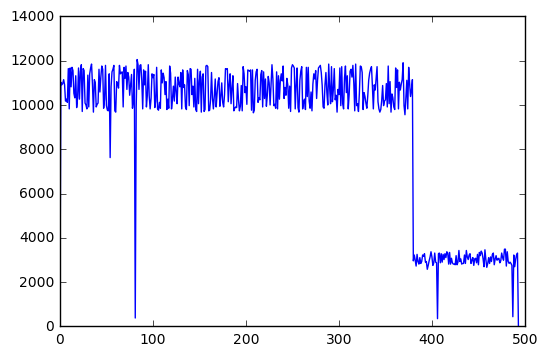

In [181]:
sub = data[26]
print len(sub)
plt.plot(sub)


28


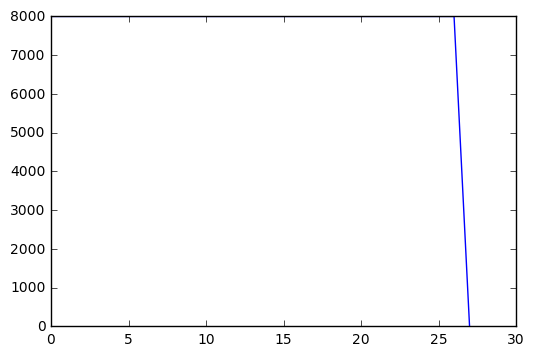

In [183]:
sub = data2[26]
print len(sub)
plt.plot(sub)
